<a href="https://colab.research.google.com/github/icapucap/SE_project/blob/main/SE_5_5optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install wandb

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD,Adam
from keras.layers import Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import glorot_normal
from keras.utils import np_utils
from keras import backend as K
from keras.datasets import cifar10
from keras.callbacks import  EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.optimizers.schedules import ExponentialDecay

import wandb
from wandb.keras import WandbCallback
wandb.init(project="vgg-cifar10")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,29
loss,0.55276
accuracy,0.82523
val_loss,0.79012
val_accuracy,0.759
_step,29
_runtime,1523
_timestamp,1603443189
best_val_loss,0.67541
best_epoch,22


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▄▅▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▆▅▆▆▇▆▇▇▇▇▇▇█▇▇▇▇▇▇█▇███▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


In [25]:
batch_size = 128
epochs = 100
learning_rate = 0.05
lr_decay = 1e-6
lr_drop = 40
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train  /= 255
x_test /= 255

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
               
datagen = ImageDataGenerator(
            featurewise_center=False, 
            samplewise_center=False,  
            featurewise_std_normalization=False,  
            samplewise_std_normalization=False,  
            zca_whitening=False,  
            rotation_range=15,  
            width_shift_range=0.1,  
            height_shift_range=0.1,  
            horizontal_flip=True, 
            vertical_flip=False)  
      
datagen.fit(x_train)


In [26]:
BATCH_NORM = True
num_classes=10

def base_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:], name='block1_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), padding='same', name='block1_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same', name='block2_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), padding='same', name='block2_conv2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv3' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv4' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv3' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv4' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv3' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv4' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dropout(0.2))

    model.add(Dense(4096 ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096, name='fc2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('softmax'))

    # sgd = SGD(lr=learning_rate, decay=lr_decay, momentum=0.75, nesterov=True)
    lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.8)
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return model







In [27]:
# in this model we replace consecutive lower convolution filters with a higher size filter
def model_replace_large():
    model = Sequential()

    model.add(Conv2D(64, (5, 5), padding='same', input_shape=x_train.shape[1:], name='block1_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    # model.add(Conv2D(64, (3, 3), padding='same', name='block1_conv2'))
    # model.add(BatchNormalization()) if BATCH_NORM else None
    # model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), padding='same', name='block2_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    # model.add(Conv2D(128, (3, 3), padding='same', name='block2_conv2' ))
    # model.add(BatchNormalization()) if BATCH_NORM else None
    # model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5, 5), padding='same', name='block3_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    # model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv2' ))
    # model.add(BatchNormalization()) if BATCH_NORM else None
    # model.add(Activation('relu'))

    model.add(Conv2D(256, (5, 5), padding='same', name='block3_conv3' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    # model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv4' ))
    # model.add(BatchNormalization()) if BATCH_NORM else None
    # model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (5, 5), padding='same', name='block4_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    # model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv2' ))
    # model.add(BatchNormalization()) if BATCH_NORM else None
    # model.add(Activation('relu'))

    model.add(Conv2D(512, (5, 5), padding='same', name='block4_conv3' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    # model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv4' ))
    # model.add(BatchNormalization()) if BATCH_NORM else None
    # model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (5, 5), padding='same', name='block5_conv1' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    # model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv2' ))
    # model.add(BatchNormalization()) if BATCH_NORM else None
    # model.add(Activation('relu'))

    model.add(Conv2D(512, (5, 5), padding='same', name='block5_conv3' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    # model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv4' ))
    # model.add(BatchNormalization()) if BATCH_NORM else None
    # model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dropout(0.3))

    model.add(Dense(4096 ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096, name='fc2' ))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('softmax'))

    # sgd = SGD(lr=learning_rate, decay=lr_decay, momentum=0.75, nesterov=True)
    lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.82)
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return model







In [28]:
cnn_n = model_replace_large()
cnn_n.summary()
cnn_n.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),callbacks=[WandbCallback(data_type="image", validation_data=(x_test, y_test), labels=class_names),
                               EarlyStopping(monitor='val_accuracy',patience=7, restore_best_weights=True)],verbose=2)
#cnn_n.save_weights('cifar10vgg.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_33 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_34 (Batc (None, 16, 16, 128)      

313/313 - 4s
0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
[[862  15  41   1  12   1   6   4  26  32]
 [  3 944   1   0   0   1   7   0   8  36]
 [ 30   6 760  12  47  38  76  16   2  13]
 [ 17  11  43 493  84 159 111  24  18  40]
 [  8   3  31   7 838  16  65  28   4   0]
 [  9   4  24  56  59 726  62  35   6  19]
 [  5   3  12   9  12   6 948   2   1   2]
 [  7   1  11  13  29  27  15 883   2  12]
 [ 33  14   4   0   6   0   2   1 912  28]
 [ 18  42   4   2   1   1   3   4  11 914]]


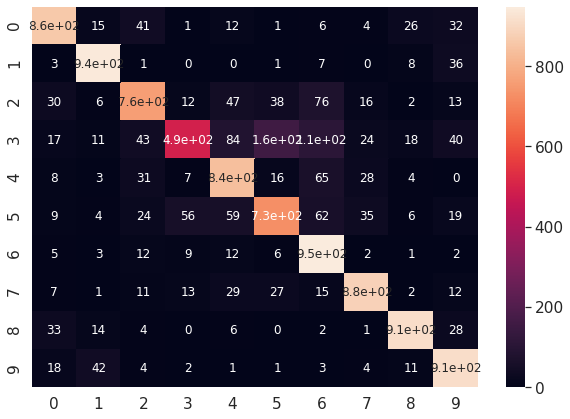

In [29]:


from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnn_n.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()